# load drifter tracks and add aviso maps

In [2]:
import re
import os

import numpy as np
#import netCDF4
import xarray as xr
import pandas as pd
#import dask.bag as db
#import dask.distributed

import datetime

import pyinterp.core
import pyinterp.trivariate

from matplotlib import pyplot as plt
%matplotlib inline

#import mitequinox.drifters as edr
import mitequinox.utils as eut

#data_dir = '/work/ALT/swot/aval/syn/drifters/'
data_dir = eut.work_data_dir+'drifters/'
aviso_dir = '/work/ALT/odatis/AVISO/2019/'

In [3]:
from dask_jobqueue import PBSCluster
#cluster = PBSCluster(cores=6, walltime='12:00:00', memory='20GB')
cluster = PBSCluster()
w = cluster.scale(1*12)
#w = cluster.scale(10) # postprocessing

/home/mp/pontea/.conda/envs/equinox/lib/python3.7/site-packages/distributed/dashboard/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [4]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)
#client = Client()

In [5]:
#client
cluster

/home/mp/pontea/.conda/envs/equinox/lib/python3.7/site-packages/distributed/scheduler.py:313: UserWarning: WorkerState.ncores has moved to WorkerState.nthreads
  warnings.warn("WorkerState.ncores has moved to WorkerState.nthreads")


In [6]:
client

Client Scheduler: tcp://10.135.39.59:57219 Dashboard: http://10.135.39.59:50283/status,Cluster Workers: 12 Cores: 24 Memory: 99.96 GB


In [9]:
#client.close()
#cluster.close()

---

In [7]:
class GridSeries:
    def __init__(self, dirname):
        self.dirname = dirname
        self.df, self.dt = self._load_ts()

    def _load_ts(self):
        pattern = re.compile(r"dt_global_allsat_phy_l4_(\d{4})(\d{2})(\d{2})_\d{8}\.nc").search
        times = []
        files = []
        for root, dirs, items in os.walk(self.dirname):
            for item in items:
                match = pattern(item)
                if match is None:
                    continue
                times.append(datetime.datetime(
                    int(match.group(1)),
                    int(match.group(2)),
                    int(match.group(3))))
                files.append(os.path.join(root, item))
        times = np.array(times)
        files = np.array(files)
        indices = np.argsort(times)

        df = pd.DataFrame(data=dict(path=files[indices]), index=times[indices])
        frequency = set(pd.Series(np.diff(df.index)).dt.total_seconds())
        if len(frequency) != 1:
            raise RuntimeError(
                "Time series does not have a constant step between two "
                f"grids: {frequency}")
        return df, datetime.timedelta(seconds=frequency.pop())

    def load_dataset(self, varname, start, end):
        if start < self.df.index[0] or end > self.df.index[-1]:
            raise IndexError(
                f"period [{start}, {end}] out of range [{self.df.index[0]}, "
                f"{self.df.index[-1]}]")
        first = start - self.dt
        last = end + self.dt

        selected = self.df[(self.df.index >= first) & (self.df.index < last)]

        x_axis = y_axis = None
        t_axis = pyinterp.core.Axis(selected.index)

        var = []

        for item in selected["path"]:
            print("*** load: " + item)
            
            #with netCDF4.Dataset(item) as ds:
            #    if x_axis is None:
            #        x_axis = pyinterp.core.Axis(
            #            ds.variables["longitude"][:])
            #        y_axis = pyinterp.core.Axis(ds.variables["latitude"][:])
                
            with xarray.open_dataset(item) as ds:
                if x_axis is None:
                    x_axis = pyinterp.core.Axis(
                        ds["longitude"].values[:])
                    y_axis = pyinterp.core.Axis(ds["latitude"].values[:])

                def _load(grid):
                    grid[grid.mask] = np.nan
                    return grid[0, :]

                #var.append(_load(ds.variables[varname][:]))
                var.append(_load(ds[varname].values[:]))

        var = np.stack(var).transpose(2, 1, 0)

        return pyinterp.trivariate.Trivariate(x_axis, y_axis, t_axis, var)

In [16]:
def cnes_jd_to_datetime(seconds):
    return datetime.datetime.utcfromtimestamp(
        ((seconds / 86400.0) - 7305.0) * 86400.0)

In [ ]:
class DataSet:
    def __init__(self, files):
        ds = xr.open_mfdataset(files, 
                    concat_dim='index', parallel=True, combine='nested')
        ds["time"] = cnes_jd_to_datetime df["time"].apply(cnes_jd_to_datetime)
        self.ds = ds.sortby(ds.t0).persist()
        
    def periods(self, grid_series, frequency='D'):
        period_start = self.df.groupby(
            self.df.index.to_period(frequency))["sla"].count().index
        period_start = self.ds.t0.groupby
        
        for start, end in zip(period_start, period_start[1:]):
            start = start.to_timestamp()
            if start < grid_series.df.index[0]:
                start = grid_series.df.index[0]
            end = end.to_timestamp()
            yield start, end
        yield end, self.df.index[-1] + grid_series.dt

    def interpolate(self, grid_series, varname, start, end):
        interpolator = grid_series.load_dataset(varname, start, end)
        mask = (self.df.index >= start) & (self.df.index < end)
        selected = self.df.loc[mask, ["lon", "lat"]]
        self.df.loc[mask, ["sla"]] = interpolator.evaluate(
            selected["lon"].values,
            selected["lat"].values,
            selected.index.values,
            interpolator="inverse_distance_weighting",
            num_threads=0)

In [9]:
ds = xr.open_mfdataset(data_dir+'single_tfilt/low_inertial_*.nc', 
                       concat_dim='index', parallel=True, combine='nested')

In [12]:
ds

<xarray.Dataset>
Dimensions:           (TIME: 721, index: 11327)
Coordinates:
  * TIME              (TIME) timedelta64[ns] 00:00:00 ... 30 days 00:00:00
Dimensions without coordinates: index
Data variables:
    LAT               (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(100, 721)>
    LON               (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(100, 721)>
    U                 (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(100, 721)>
    V                 (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(100, 721)>
    LAT_ERR           (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(100, 721)>
    LON_ERR           (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(100, 721)>
    U_ERR             (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(100, 721)>
    V_ERR             (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(100, 721)>
    DROGUE       

In [14]:
ds = ds.sortby(ds.t0).persist()

/home/mp/pontea/.conda/envs/equinox/lib/python3.7/site-packages/xarray/core/indexing.py:1201: PerformanceWarning: Slicing with an out-of-order index is generating 81 times more chunks
  return self.array[key]
/home/mp/pontea/.conda/envs/equinox/lib/python3.7/site-packages/distributed/scheduler.py:313: UserWarning: WorkerState.ncores has moved to WorkerState.nthreads
  warnings.warn("WorkerState.ncores has moved to WorkerState.nthreads")


/home/mp/pontea/.conda/envs/equinox/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


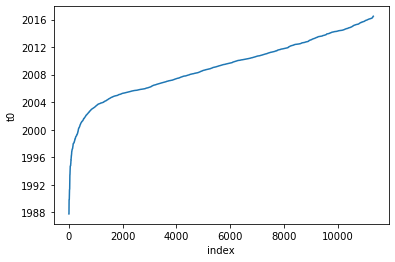

/home/mp/pontea/.conda/envs/equinox/lib/python3.7/site-packages/distributed/scheduler.py:313: UserWarning: WorkerState.ncores has moved to WorkerState.nthreads
  warnings.warn("WorkerState.ncores has moved to WorkerState.nthreads")


In [15]:
ds.t0.plot()

In [19]:
ds.t0

<xarray.DataArray 't0' (index: 11327)>
dask.array<shape=(11327,), dtype=datetime64[ns], chunksize=(3,)>
Dimensions without coordinates: index

In [22]:
lt = ds.t0.isel(index=0).values

/home/mp/pontea/.conda/envs/equinox/lib/python3.7/site-packages/distributed/scheduler.py:313: UserWarning: WorkerState.ncores has moved to WorkerState.nthreads
  warnings.warn("WorkerState.ncores has moved to WorkerState.nthreads")


In [23]:
dir(lt)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_interface__',
 '__array_priority__',
 '__array_struct__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__le__',
 '__lshift__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rlshift__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__round__',
 '__rpow__',
 '__rrshift__',
 '__rshift__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__xor__',
 'all',
 'any',
 'argmax',
 'argmin',
 'a

In [ ]:
ds.t

In [7]:
ds = ds.chunk({'index': 500})
ds['UV'] = (ds.U + 1j * ds.V).where(~np.isnan(ds.U*ds.V), other=np.nan)
ds['f'] = eut.coriolis(ds.LAT, signed=True)
ds['depth'] = edr.compute_depth(ds.LON, ds.LAT)

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/pandas/core/indexes/base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |


In [8]:
ds = ds.persist()

check typical percentages of bad points

(array([   21.,    18.,    13.,    17.,    28.,    32.,    26.,    34.,
           65., 11073.]),
 array([0.9001387 , 0.91012483, 0.92011096, 0.93009709, 0.94008322,
        0.95006935, 0.96005548, 0.97004161, 0.98002774, 0.99001387,
        1.        ]),
 <a list of 10 Patch objects>)

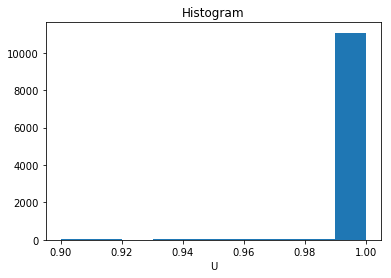

In [9]:
gd_points_percent = ( ds.U.where(np.isnan(ds.U), other=1.)
                      .fillna(0.).sum('TIME')/len(ds.TIME) )
gd_points_percent.plot.hist()

In [10]:
# interpolate NaNs
ds['UV'] = ds.UV.fillna(0.)
# below not working, xarray version issue?
#ds['UV'] = ds.UV.interpolate_na(dim='TIME', method='linear', 
#                                limit=12, right=0., left=0.)

---

In [25]:
cluster.close()